# Projekt - Prepoznavanje raka pluća i debelog crijeva na slikama koristeći CNN


Prije svega, potrebno je učitati sve potrebne importe.

In [177]:
import os
import pickle
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix

from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, BatchNormalization
from keras.callbacks import ModelCheckpoint, CSVLogger
from keras.optimizers import Adam
from keras.applications import ResNet50, MobileNetV2

import matplotlib.pyplot as plt
import matplotlib.image as mpimg

Dodatno, za slučaj da ne postoje, trebali bismo inicijalizirati direktorije gdje će biti pohranjeni modeli, kao i statistike vezane uz njih.

In [10]:
dirs = ['./models', './stats', './images']

for dir in dirs:
    if not os.path.exists(dir): 
        os.makedirs(dir)

Prije nego što krenemo učiti modele, potrebno je učitati skup podataka.

In [3]:
# data_folder = '/kaggle/input/neumre/data'
data_folder = './data'

file_paths = []
labels = []

class_folders = os.listdir(data_folder)
for class_folder in class_folders:
    class_folder_path = os.path.join(data_folder, class_folder)
    class_files = os.listdir(class_folder_path)

    for file in class_files:
        file_path = os.path.join(class_folder_path, file)
        
        file_paths.append(file_path)
        
        if class_folder == 'colon_aca':
            labels.append('Colon Adenocarcinoma')
        elif class_folder == 'colon_n':
            labels.append('Colon Benign Tissue')
        elif class_folder == 'lung_aca':
            labels.append('Lung Adenocarcinoma')
        elif class_folder == 'lung_n':
            labels.append('Lung Benign Tissue')
        elif class_folder == 'lung_scc':
            labels.append('Lung Squamous Cell Carcinoma')

file_series = pd.Series(file_paths, name='filepath')
label_series = pd.Series(labels, name='label')
data = pd.concat([file_series, label_series], axis=1)

print(data.describe())

                                filepath                 label
count                              25000                 25000
unique                             25000                     5
top     ./data/lung_scc/lungscc3298.jpeg  Colon Adenocarcinoma
freq                                   1                  5000


Možemo vizualizirati nekoliko slika kako bismo potvrdili da je učitavanje uspješno.

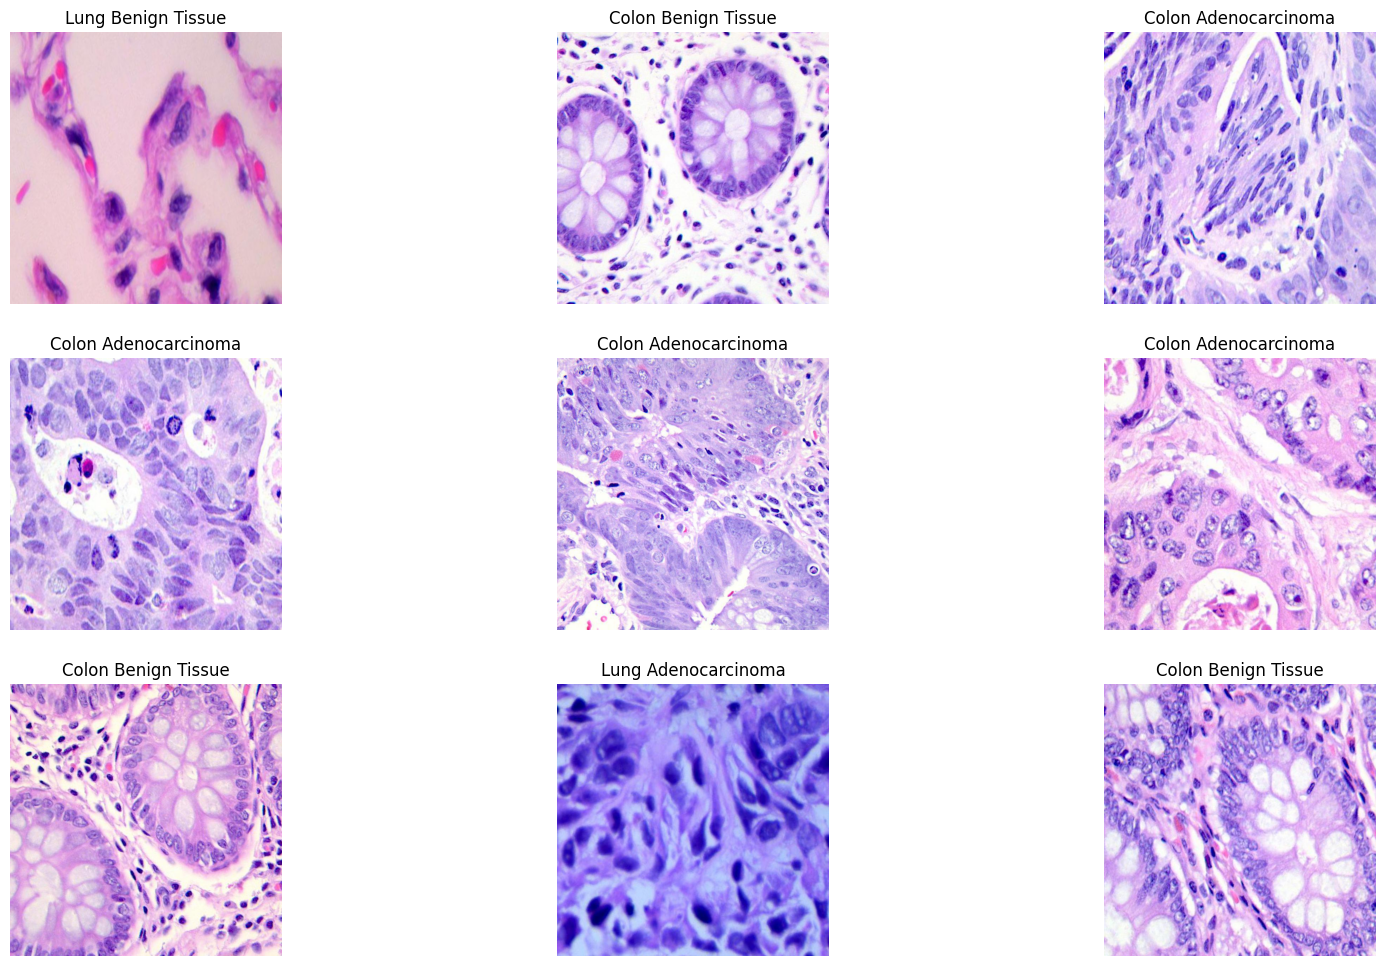

In [12]:
num_rows = 3
num_cols = 3
num_images = num_rows * num_cols

plt.figure(figsize=(20,12))

for i in range(num_images):
    row_num = np.random.randint(0, data.shape[0])
    row = data.iloc[[row_num]]
    img = mpimg.imread(row['filepath'].item())

    plt.subplot(num_rows, num_cols, i + 1)
    plt.gca().set_title(row['label'].item())
    plt.gca().axis('off')
    plt.imshow(img)

plt.show()

Sljedeći korak je podijeliti skup podataka na tri disjunktna skupa: skup za učenje, ispitivanje i validaciju. 

In [4]:
train_data, temp_data = train_test_split(data, train_size=0.7, shuffle=True, random_state=100)
validation_data, test_data = train_test_split(temp_data,  train_size=1/3, shuffle=True, random_state=100)

Kada imamo sva tri skupa, potrebno je kreirati generatore koji će dohvaćati mini-grupe iz skupova, kao i obavljati dodatne poslove poput miješanja (shuffle) podataka. Kao veličinu mini-grupe stavit ćemo 16. Naravno, ovu veličinu možemo po volji podešavati.

In [5]:
batch_size = 16
image_size = (224, 224)
num_channels = 3

image_shape = (image_size[0], image_size[1], num_channels)
num_classes = 5

train_generator = ImageDataGenerator().flow_from_dataframe(train_data, x_col='filepath', y_col='label', target_size=image_size, class_mode='categorical', 
                                                           color_mode='rgb', shuffle=True, batch_size=batch_size)
validation_generator = ImageDataGenerator().flow_from_dataframe(validation_data, x_col='filepath', y_col='label', target_size=image_size, class_mode='categorical', 
                                                                color_mode='rgb', shuffle=False, batch_size=batch_size)
test_generator = ImageDataGenerator().flow_from_dataframe(test_data, x_col='filepath', y_col='label', target_size=image_size, class_mode='categorical', 
                                                          color_mode='rgb', shuffle=False, batch_size=batch_size)

classes = list(train_generator.class_indices.keys())

Found 17500 validated image filenames belonging to 5 classes.
Found 2500 validated image filenames belonging to 5 classes.
Found 5000 validated image filenames belonging to 5 classes.


Sljedeći korak nam je odabrati model. Kao prvi model odabrat ćemo ResNet50 model s težinama naučenim na ImageNet skupu. Ovaj model prilagodit ćemo našem problemu - na izlaz ćemo dodati nekoliko potpuno-povezanih slojeva (kao i sloj za normalizaciju te dropout sloj), od kojih će posljednji sloj imati broj izlaza jednak broju razreda. Tada će predikcija modela odgovarati izlazu s najvećom vrijednošću (aktivacijska funkcija u posljednjem sloju bit će softmax).

In [12]:
def get_resnet_50():
    pretrained_model = ResNet50(input_shape=image_shape, weights='imagenet', include_top=False)
    pretrained_model.trainable = False

    model = Sequential([
        pretrained_model,
        BatchNormalization(),
        Flatten(),
        Dense(256, activation='relu'),
        Dropout(0.5),
        Dense(num_classes, activation='softmax')
    ], name='ResNet50')

    model.compile(Adam(learning_rate=0.00075), loss='categorical_crossentropy', metrics=['accuracy'])

    return model

resnet50_model = get_resnet_50()
resnet50_model.summary()

Model: "ResNet50"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 7, 7, 2048)        23587712  
                                                                 
 batch_normalization_3 (Bat  (None, 7, 7, 2048)        8192      
 chNormalization)                                                
                                                                 
 flatten_3 (Flatten)         (None, 100352)            0         
                                                                 
 dense_6 (Dense)             (None, 256)               25690368  
                                                                 
 dropout_3 (Dropout)         (None, 256)               0         
                                                                 
 dense_7 (Dense)             (None, 5)                 1285      
                                                          

Sada možemo naučiti model, pritom koristeći skupove podataka za učenje i validaciju. Potrebno je odrediti broj epoha. Za početak ćemo isprobati učenje modela s ukupno 10 epoha. Pritom ćemo dodatno dodati dva callback-a: jedan za pohranu težina modela, a drugi za pohranu ispisa učenja u CSV formatu. Na kraju učenja, statistike modela (točnost, gubitak kroz epohe, itd.) ćemo pohraniti u zasebnu datoteku.

In [262]:
def train_model(model, num_epochs=10):
    dirs = ['./models', './stats', './images']

    for dir in dirs:
        if not os.path.exists(f'{dir}/{model.name}'): 
            os.makedirs(f'{dir}/{model.name}')

    checkpoint_saver = ModelCheckpoint(
        filepath=f'./models/{model.name}/model',
        monitor='val_accuracy',
        mode='max',
        save_weights_only=True,
        save_best_only=True,
    )

    log_saver = CSVLogger(f'./stats/{model.name}/logs.csv')

    stats = model.fit(x=train_generator, epochs=num_epochs, validation_data=validation_generator, verbose=1, callbacks=[checkpoint_saver, log_saver])

    with open(f'./stats/{model.name}/stats.txt', 'wb') as file:
        pickle.dump(stats.history, file)

Definirajmo broj epoha i pokrenimo učenje.

In [ ]:
num_epochs = 25
train_model(resnet50_model, num_epochs)

Nakon što imamo naučeni model, na temelju statistike dobivene za njega tijekom učenja možemo iscrtati graf gubitka na zasebnim skupovima po epohama, kao i graf točnosti (_accuracy_).

In [217]:
def graph_accuracy_and_loss(stats, save_path=None):
    train_accuracy = stats.get('accuracy')
    validation_accuracy = stats.get('val_accuracy')

    train_loss = stats.get('loss')
    validation_loss = stats.get('val_loss')

    epochs = list(range(1, len(train_accuracy) + 1))

    plt.figure(figsize=(16,10))

    plt.subplot(1,2,1)
    plt.plot(epochs, train_accuracy, c='blue', label='Train accuracy')
    plt.plot(epochs, validation_accuracy, c='orange', label='Validation accuracy')
    plt.title('Accuracy over epochs')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.subplot(1,2,2)
    plt.plot(epochs, train_loss, c='blue', label='Train loss')
    plt.plot(epochs, validation_loss, c='orange', label='Validation loss')
    plt.title('Loss over epochs')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    if save_path:
        plt.savefig(save_path)
    else:
        plt.show()


def load_stats(model):
    with open(f'./stats/{model.name}/stats.txt', 'rb') as file:
        stats = pickle.load(file)   
    
    return stats

Dohvatimo statove ta Resnet50 i iscrtajmo grafikone.

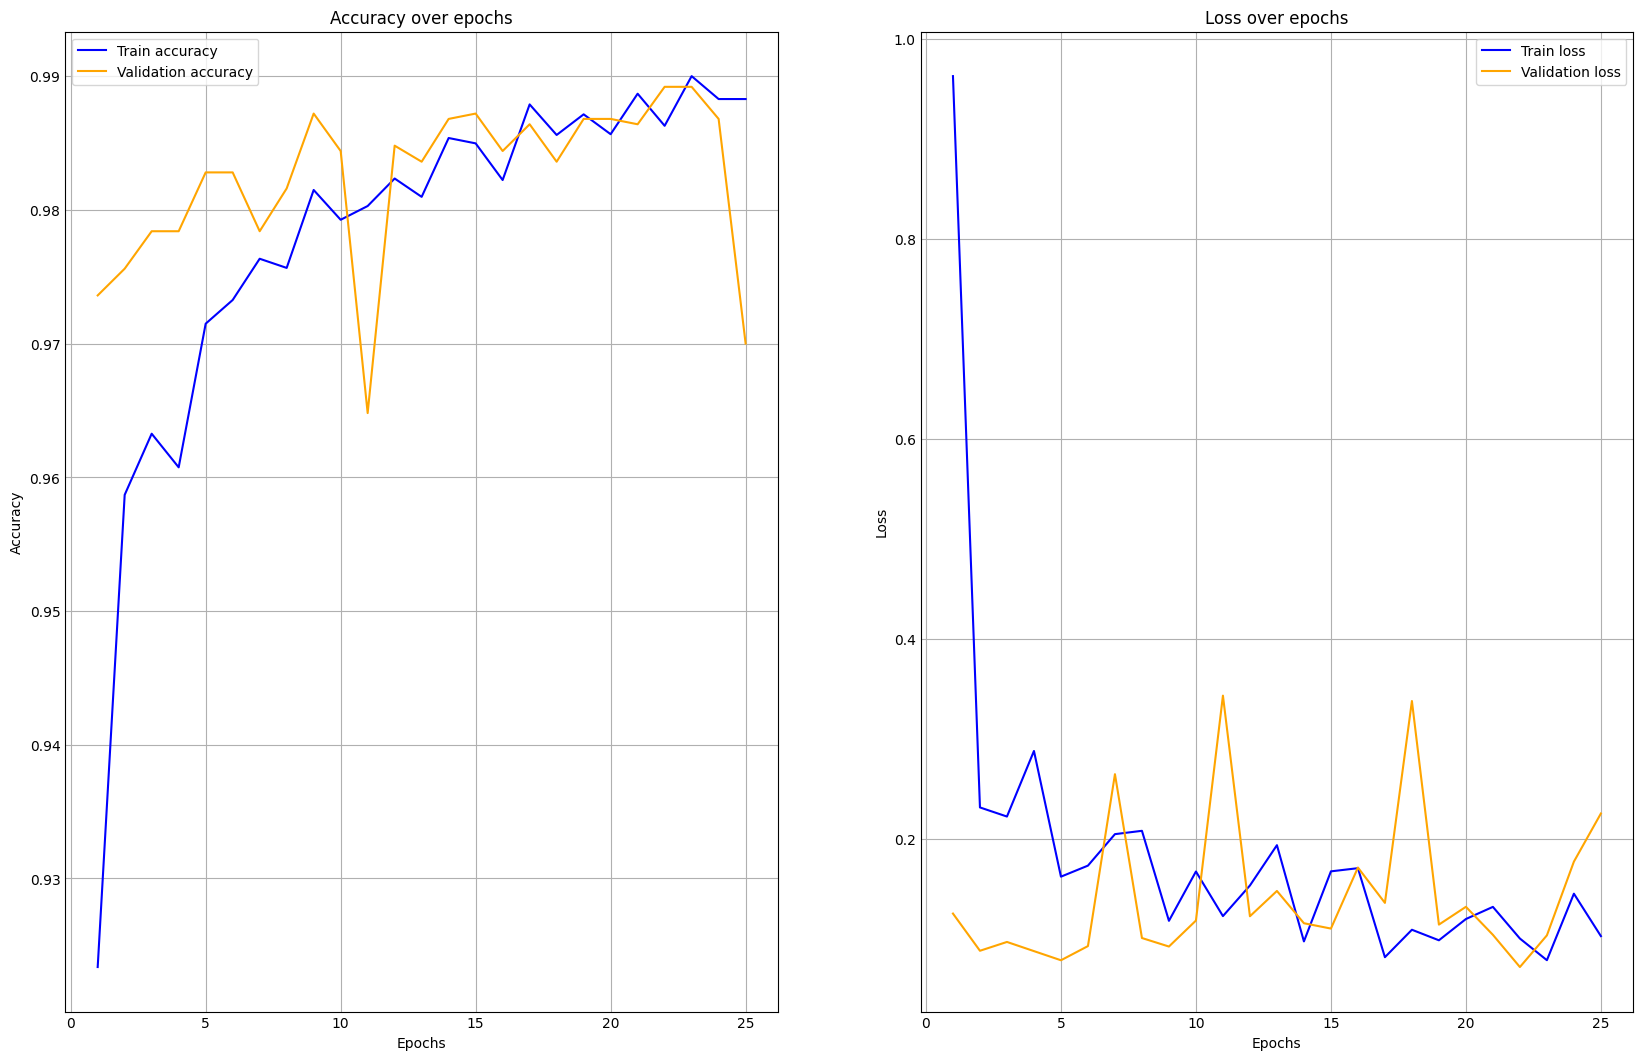

In [216]:
resnet50_stats = load_stats(resnet50_model)
graph_accuracy_and_loss(resnet50_stats, f'./images/{resnet50_model.name}/accuracy_loss.png')

Konačno, možemo ispitati performanse naučenog modela na skupu za ispitivanje (_test set_).

In [14]:
def get_model_weights_path(model):
    return f'./models/{model.name}/model'


resnet50_model = get_resnet_50()
resnet50_model.load_weights(get_model_weights_path(resnet50_model))

results = resnet50_model.evaluate(test_generator, verbose=1)

313/313 [==============================] - 13s 39ms/step - loss: 0.1237 - accuracy: 0.9894


Ove rezultate dodatno ćemo formatirati zbog ljepšeg ispisa, a onda i pohraniti u stats direktorij.

In [16]:
def print_results(model, results):
    print(f'Model: {model.name}')
    print(f'Test accuracy: {results[1]}')
    print(f'Test loss: {results[0]}')

    with open(f'./stats/{model.name}/test_stats', 'w') as file:
        file.write(f'Test accuracy: {results[1]}\n')
        file.write(f'Test loss: {results[0]}')

print_results(resnet50_model, results)

Model: ResNet50
Test accuracy: 0.9894000291824341
Test loss: 0.12373816221952438


Sada kada smo prikazali testnu preciznost i gubitak, ostaje nam još prikazati konfuzijsku matricu i nekoliko mjera dobrote. Dodatno kreiramo fuknciju za dohvat predikcija.

In [ ]:
def get_class_predictions(model):
    model_predictions = model.predict(test_generator)
    return np.argmax(model_predictions, axis=1)

313/313 [==============================] - 11s 34ms/step


Dohvatimo sada predikcije klasa.

In [232]:
resnet50_class_predictions = get_class_predictions(resnet50_model)

313/313 [==============================] - 11s 36ms/step


Kreirajmo funkciju za prikaz konfuzijske matrice.

In [ ]:
def show_confusion_matrix(model, class_predictions):
    confusiom_mat = confusion_matrix(test_generator.classes, class_predictions)

    plt.figure(figsize=(15, 5))
    plt.imshow(confusiom_mat, cmap=plt.cm.Greens)
    plt.title("Confusion Matrix")
    plt.colorbar()

    for i, val in enumerate(test_generator.class_indices.keys()):
        print(f"Class {i} is for {val}.")

    plt.tight_layout()
    plt.ylabel('Real Label')
    plt.xlabel('Predicted Label')

    thresh = confusiom_mat.max() / 2.
    cm_color = lambda x: "white" if x > thresh else "black"
    for i, row in enumerate(confusiom_mat):    
        for j, col in enumerate(confusiom_mat[i]):
            percentage = round(confusiom_mat[i, j]/len(class_predictions) * 100, 2)
            text = f"{confusiom_mat[i, j]}\n{percentage}%"
            plt.text(j, i, text, horizontalalignment="center", verticalalignment="center", color=cm_color(confusiom_mat[i, j]))

    return confusiom_mat

Potom prikažimo konfucijsku matricu.

Class 0 is for Colon Adenocarcinoma.
Class 1 is for Colon Benign Tissue.
Class 2 is for Lung Adenocarcinoma.
Class 3 is for Lung Benign Tissue.
Class 4 is for Lung Squamous Cell Carcinoma.


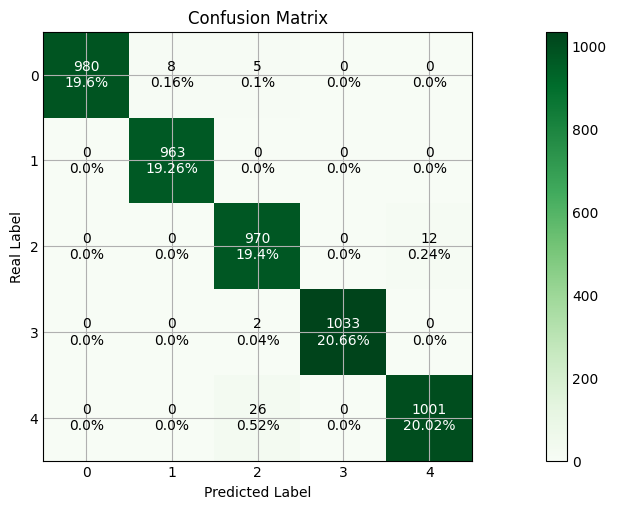

In [ ]:
resnet50_conf_matrix = show_confusion_matrix(resnet50_model, resnet50_class_predictions)

Isto tako, kreiramo funkciju za prikaz raznih grafova performansi.

In [251]:
def show_performance_graphs(conf_matrix):
    N = np.sum(np.concatenate(conf_matrix))
    FP = np.sum(conf_matrix, axis=1)
    FN = np.sum(conf_matrix, axis=0)

    x = np.arange(len(classes))
    width = 0.13
    multiplier = 0

    fig, ax = plt.subplots(layout='constrained')

    accs = []
    precs = []
    F1s = []
    recs = []
    specs = []

    for i in range(len(conf_matrix)):
        TP_i = conf_matrix[i, i]
        FP_i = FP[i] - TP_i
        FN_i = FN[i] - TP_i
        TN_i = N - TP_i - FP_i - FN_i

        acc = (TP_i + TN_i) / (TN_i + TP_i + FN_i + FP_i) * 100
        prec = (TP_i) / (TP_i + FP_i) * 100
        F1 = (TP_i) / (TP_i + 0.5 * (FN_i + FP_i)) * 100
        rec = (TP_i) / (TP_i + FN_i) * 100
        spec = (TN_i) / (TN_i + FP_i) * 100

        accs.append(round(acc, 2))
        precs.append(round(prec,2))
        F1s.append(round(F1,2))
        recs.append(round(rec,2))
        specs.append(round(spec,2))

    measurements = {"Accuracy": accs, "Precision": precs, "F-1 Score": F1s, "Recall": recs, "Specificity": specs}
    colors = ["orange", "yellow", "green", "brown", "blue"]

    for i, item in enumerate(measurements.items()):
        key, val = item
        measurement = (val[0], val[1], val[2], val[3], val[4])

        offset = width * multiplier
        rects = ax.bar(x + offset, measurement, width=width-0.02, label=key, color=colors[i])
        ax.bar_label(rects, padding=3, rotation=45)
        multiplier += 1

    ax.set_title('Mjere dobrote po klasi')
    ax.set_ylabel("Percentage (%) ")
    ax.set_xticks(x + width + 0.1, classes)
    ax.legend(loc='upper left', ncols=5)
    ax.set_ylim(95, 102)

    fig.set_figwidth(15)
    fig.set_figheight(5)

    plt.show()

Prakažimo grafove performansi.

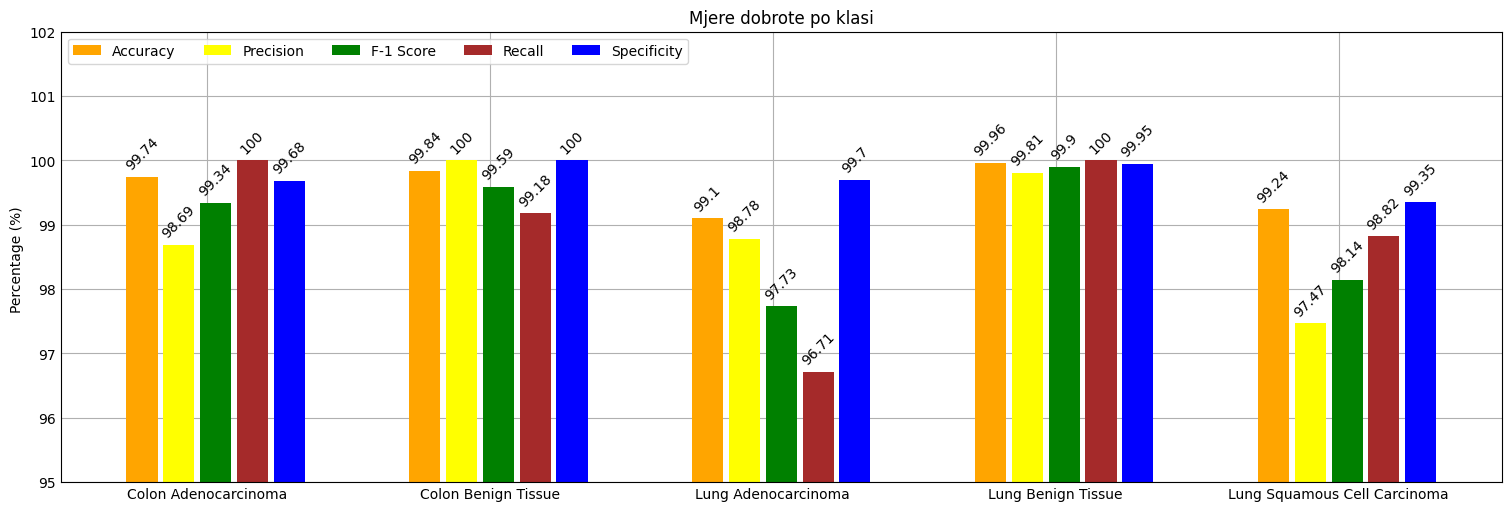

In [255]:
show_performance_graphs(resnet50_conf_matrix, classes)

Osim prethodno odrađene Resnet50 mreže, postoji niz drugih mreža koje smo mogli isprobati, jedna od njih je MobileNetV2 mreža koja radi sa znatno manja parametara pa je pogodna za ugradnju u embeded uređaje. Dodatna razlika u odnosu na prethodnu mrežu je manjak slojeva koje dodajemo na izlaz te sada još i treniramo cijelu mrežu.

In [265]:
def get_mobilenet_v2():
    pretrained_model = MobileNetV2(input_shape=image_shape, weights='imagenet', include_top=False)
    pretrained_model.trainable = True

    model = Sequential([
        pretrained_model,
        BatchNormalization(),
        Flatten(),
        Dense(num_classes, activation='softmax')
    ], name='MobileNetV2')

    model.compile(Adam(), loss='categorical_crossentropy', metrics=['accuracy'])

    return model

mobile_net_v2_model = get_mobilenet_v2()
mobile_net_v2_model.summary()

Model: "MobileNetV2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 mobilenetv2_1.00_224 (Func  (None, 7, 7, 1280)        2257984   
 tional)                                                         
                                                                 
 batch_normalization_16 (Ba  (None, 7, 7, 1280)        5120      
 tchNormalization)                                               
                                                                 
 flatten_17 (Flatten)        (None, 62720)             0         
                                                                 
 dense_37 (Dense)            (None, 5)                 313605    
                                                                 
Total params: 2576709 (9.83 MB)
Trainable params: 2540037 (9.69 MB)
Non-trainable params: 36672 (143.25 KB)
_________________________________________________________________


Pokrenimo sada treniranje našeg MobileNetV2 modela.

In [266]:
num_epochs = 15
mobile_net_v2_model = get_mobilenet_v2()
train_model(mobile_net_v2_model, num_epochs)

Epoch 1/15
1094/1094 [==============================] - 63s 49ms/step - loss: 2.3608 - accuracy: 0.8238 - val_loss: 543.8408 - val_accuracy: 0.2016
Epoch 2/15
1094/1094 [==============================] - 53s 48ms/step - loss: 1.7338 - accuracy: 0.8517 - val_loss: 416.3707 - val_accuracy: 0.2016
Epoch 3/15
1094/1094 [==============================] - 53s 48ms/step - loss: 1.1662 - accuracy: 0.8879 - val_loss: 22.1489 - val_accuracy: 0.6880
Epoch 4/15
1094/1094 [==============================] - 52s 48ms/step - loss: 1.0345 - accuracy: 0.8911 - val_loss: 75.2497 - val_accuracy: 0.3668
Epoch 5/15
1094/1094 [==============================] - 53s 48ms/step - loss: 0.4225 - accuracy: 0.9301 - val_loss: 141.1531 - val_accuracy: 0.4236
Epoch 6/15
1094/1094 [==============================] - 54s 49ms/step - loss: 0.5061 - accuracy: 0.9266 - val_loss: 3.7325 - val_accuracy: 0.7432
Epoch 7/15
 855/1094 [======================>.......] - ETA: 10s - loss: 0.3361 - accuracy: 0.9364

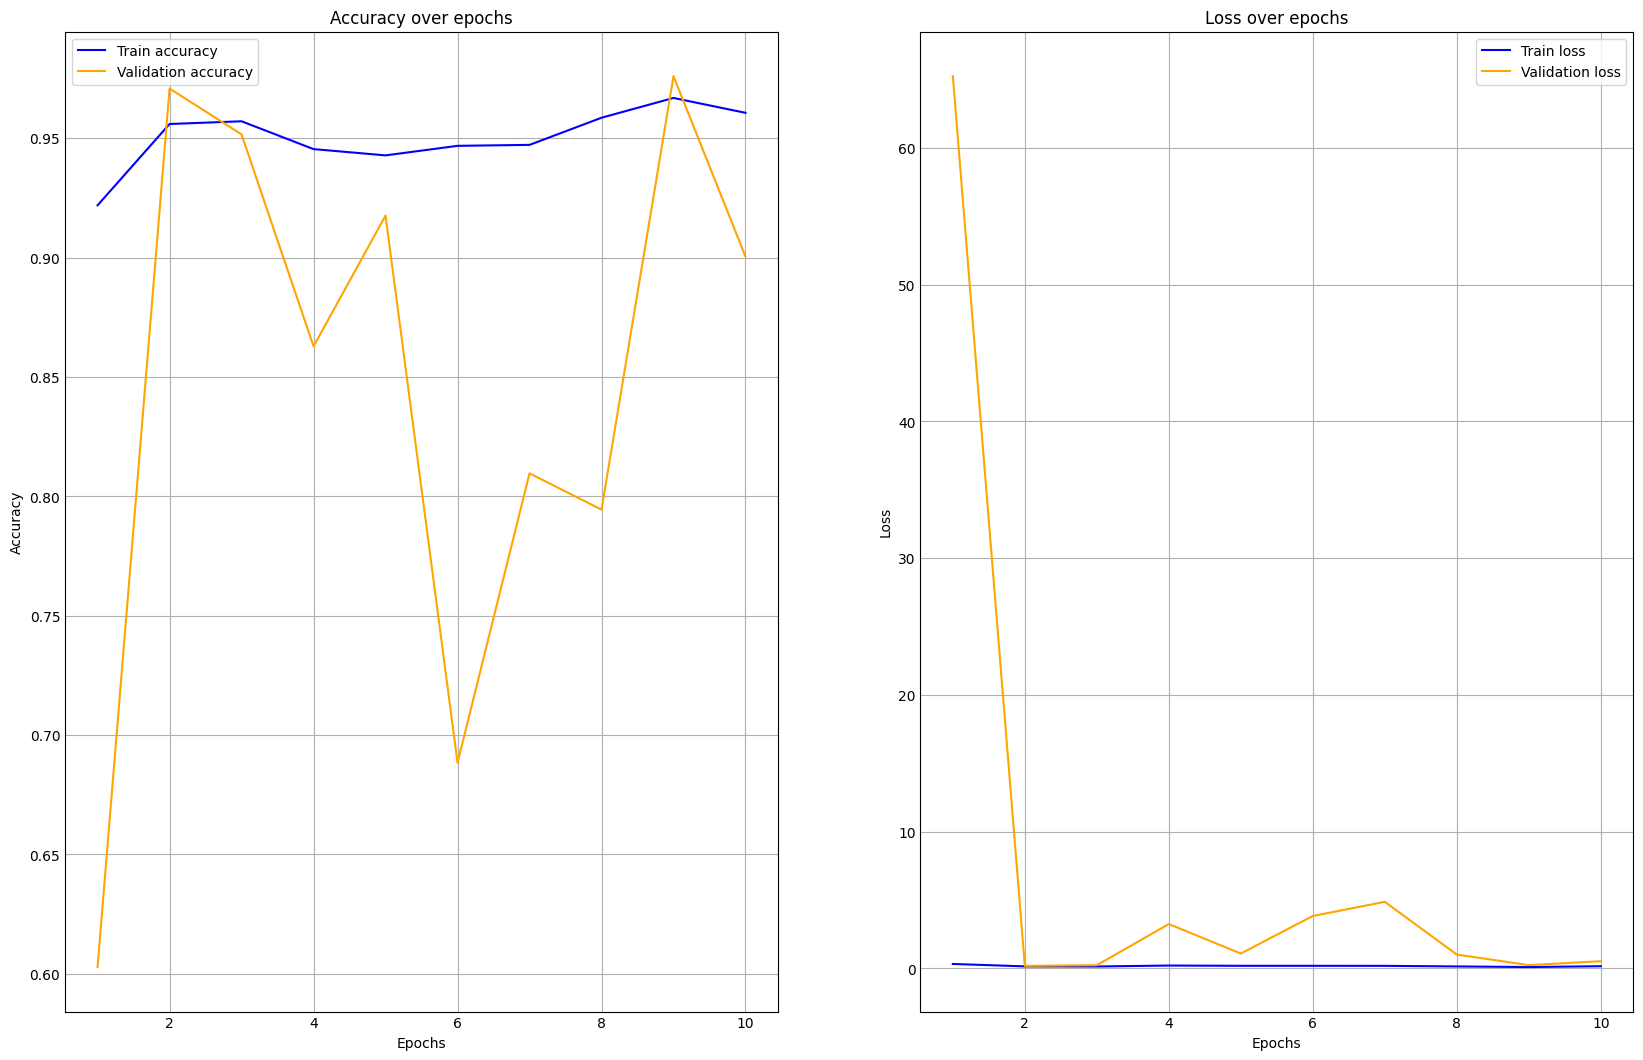

In [215]:
mobilenet_v2_stats = load_stats(mobile_net_v2_model)
graph_accuracy_and_loss(mobilenet_v2_stats, f'./images/{mobile_net_v2_model.name}/accuracy_loss.png')

In [204]:
mobilenet_v2_model = get_mobilenet_v2()
mobilenet_v2_model.load_weights(get_model_weights_path(mobilenet_v2_model))
mobilenet_results = mobilenet_v2_model.evaluate(test_generator, verbose=1)

313/313 [==============================] - 7s 22ms/step - loss: 0.2515 - accuracy: 0.9762


In [205]:
print_results(mobile_net_v2_model, mobilenet_results)

Model: MobileNet
Test accuracy: 0.9761999845504761
Test loss: 0.2514616549015045
